In [1]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import pandas as pd

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts'])
bwb = pd.read_csv('./takeoff-merged-VP-BWB-30s.csv', parse_dates=['reportts'])
bcr = pd.read_csv('./takeoff-merged-VQ-BCR-30s.csv', parse_dates=['reportts'])

fleet = ['VQ-BGU', 'VQ-BDU']

dataset = pd.concat([bgu, bdu, bwb, bcr]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts')

dataset = dataset[dataset['acnum'].isin(fleet)].dropna(subset=['egtm'])

In [3]:
def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = Ridge(alpha=40)
  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  mse = mean_squared_error(y_train, predicted_train, squared=False)
  mae = mean_absolute_error(y_train, predicted_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)

  return mse, mae, model, predicted_train, predicted_test, train_i, y_test

In [4]:
adj_features = [
  'hpcbf', 'ff', 'nait', 'fmvc', 'tn', 'p2e', 'sva', 'lpbt', 'gle', 'tfuel', 
  'tat',  'ffr', 'n1p', 'cas', 'vorrc', 'n2c5', 'joip', 'lpt', 'n2a', 'hpctc', 'n2p', 
  'lpcsv', 'pf', 'gw', 'n1c2', 'ttp', 'ps14', 'nai', 'fvd', 'lpctc', 'foc', 'cg', 'w14'
]

In [5]:
X = dataset[adj_features].fillna(0)
y = dataset['egtm']

mse, mae, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

mse, mae

(5.172013940310437, 3.1311095685756514)

In [6]:
pr = pd.Series(predicted_test)
avg_test = ([None] * train_i) + pr.ewm(alpha=1 / 20).mean().to_list()

In [7]:
pr = pd.Series(predicted_train)
avg_train = pr.ewm(alpha=1 / 20).mean().to_list() + ([None] * (len(dataset) - train_i)) 

In [8]:
mse = mean_squared_error(y[:train_i], avg_train[:train_i], squared=False)
mse

4.548495208735071

In [9]:
mse = mean_squared_error(y[train_i:], predicted_test, squared=False)
mse

5.172013940310437

In [10]:
mse = mean_squared_error(y[train_i:], avg_test[train_i:], squared=False)
mse

2.7229208750731186

In [11]:
dataset.insert(4, 'train_pred', avg_train)
dataset.insert(5, 'test_pred', avg_test)

/tmp/ipykernel_33884/3949875052.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.insert(4, 'train_pred', avg_train)
/tmp/ipykernel_33884/3949875052.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.insert(5, 'test_pred', avg_test)


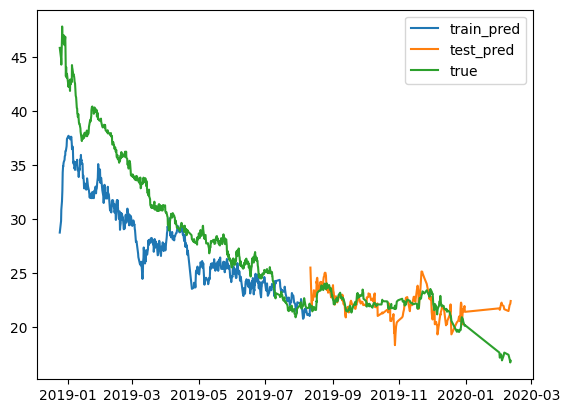

In [12]:
import matplotlib.pyplot as plt

sub = dataset[(dataset['acnum'] == 'VQ-BGU') & (dataset['pos'] == 2)]

plt.plot(sub['reportts'], sub['train_pred'], '-')
plt.plot(sub['reportts'], sub['test_pred'], '-')
plt.plot(sub['reportts'], sub['egtm'], '-')

plt.legend(['train_pred', 'test_pred', 'true'])
plt.show()

In [13]:
dataset.to_csv('viz-baseline.csv', index=False)